In [137]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
def lennard_jones_potential(r, sigma: float, eps: float) -> np.ndarray:
    return 4*eps*np.power(sigma, 12)/np.power(r, 12) - 4*eps*np.power(sigma, 6)/np.power(r, 6)

def lennard_jones_force(r, sigma: float, eps: float) -> np.ndarray:
    return 24*eps*np.power(sigma, 6)/np.power(r, 7) - 48*eps*np.power(sigma, 12)/np.power(r, 13)

def get_kinetic_energy(m, v):
    return m*(v**2)/2

def get_verlet_next_x(x, v, f, m, dt):
    a = f/m
    return x + v*dt + a*(dt**2)/2

def get_verlet_next_f(rs, sigma: float, eps: float):
    return np.sum(lennard_jones_force(rs, sigma, eps))

def get_verlet_next_u(rs, sigma: float, eps: float):
    return np.sum(lennard_jones_potential(rs, sigma, eps))/2

def get_verlet_next_v(v, f, f_next, m, dt):
    a, a_next = f/m, f_next/m
    return v + ((a + a_next)*dt)/2

def verlet_next(rs, v, f, m, dt, sigma, eps):
    f_next = get_verlet_next_f(rs, sigma, eps)
    u_next = get_verlet_next_u(rs, sigma, eps)
    v_next = get_verlet_next_v(v, f, f_next, m, dt)
    ek_next = get_kinetic_energy(m, v_next)
    
    return v_next, f_next, u_next, ek_next

In [139]:
# %% Parameters
SIGMA = 1
EPS = 1.5
SIMULATION_TIME = 10

# %% Indexes
P_ID, P_M, P_X, P_V, P_F, P_X_NEXT, P_V_NEXT, P_F_NEXT = 0, 1, 2, 3, 4, 5, 6, 7
R_X, R_V, R_F, R_U, R_EK, R_ET, R_T = 0, 1, 2, 3, 4, 5, 6

In [140]:
def verlet_algo(particles: np.ndarray, simulation_time: float, dt: float, sigma: float, eps: float) -> np.ndarray:
    time = np.arange(0, simulation_time + dt, dt)
    
    result = np.zeros(shape=(particles.shape[0], time.shape[0], 7))
    result[:, 0, R_X] = particles[:, P_X]
    result[:, 0, R_V] = particles[:, P_V]
    result[:, 0, R_F] = particles[:, P_F]
    result[:, 0, R_U] = 0
    result[:, 0, R_EK] = 0
    result[:, 0, R_ET] = 0
    result[:, :, R_T] = time
    
    # рассчитаем начальные силы и энергии
    for i in range(particles.shape[0]):
        p = particles[i]
        p_id = p[P_ID].astype(np.int64)
        neighbours = particles[particles[:, P_ID] != p[P_ID]]
       
        r = neighbours[:, P_X] - p[P_X]
        v, f, u, ek = verlet_next(r, p[P_V], p[P_F], p[P_M], dt, sigma, eps)

        particles[i, P_F] = f

        result[p_id, 0, R_U] = u
        result[p_id, 0, R_F] = f
        result[p_id, 0, R_EK] = ek
        result[p_id, 0, R_ET] = ek + u
    
    for curr in range(len(time) - 1):
        next = curr + 1
        
        # для всех посчитаем следующую координату
        particles[:, P_X_NEXT] = get_verlet_next_x(particles[:, P_X], particles[:, P_V], particles[:, P_F], particles[:, P_M], dt)
            
        for i in range(particles.shape[0]):
            p = particles[i]
            p_id = p[P_ID].astype(np.int64)
            neighbours = particles[particles[:, P_ID] != p[P_ID]]
            
            r = neighbours[:, P_X_NEXT] - p[P_X_NEXT]
            v_next, f_next, u_next, ek_next = verlet_next(r, p[P_V], p[P_F], p[P_M], dt, sigma, eps)
            
            p[P_V_NEXT] = v_next
            p[P_F_NEXT] = f_next
            
            result[p_id, next, R_X] = p[P_X_NEXT]
            result[p_id, next, R_V] = v_next
            result[p_id, next, R_F] = f_next
            result[p_id, next, R_U] = u_next
            result[p_id, next, R_EK] = ek_next
            result[p_id, next, R_ET] = ek_next + u_next
        
        # применим изменения параметров к частицам
        particles[:, P_X] = particles[:, P_X_NEXT]
        particles[:, P_V] = particles[:, P_V_NEXT]
        particles[:, P_F] = particles[:, P_F_NEXT]

    return result

In [141]:
delta_t = 0.01

particles = np.array([
    #id,m, x, v, f, xn,vn,fn
    [0, 2, 10, 0, 0, 0, 0, 0],
    [1, 1, 12, 0, 0, 0, 0, 0],
    [2, 3, 14, 0, 0, 0, 0, 0],
], dtype=np.float64)

data = verlet_algo(particles, SIMULATION_TIME, delta_t, SIGMA, EPS)

time = data[0, :, R_T]

x1_verlet = data[0, :, R_X]
x2_verlet = data[1, :, R_X]
x3_verlet = data[2, :, R_X]

v1_verlet = data[0, :, R_V]
v2_verlet = data[1, :, R_V]
v3_verlet = data[2, :, R_V]

total_energy_verlet = np.sum(data[:, :, R_ET], axis=0)
potential_verlet = np.sum(data[:, :, R_U], axis=0)
energy_kinetic1_verlet = data[0, :, R_EK]
energy_kinetic2_verlet = data[1, :, R_EK]
energy_kinetic3_verlet = data[2, :, R_EK]

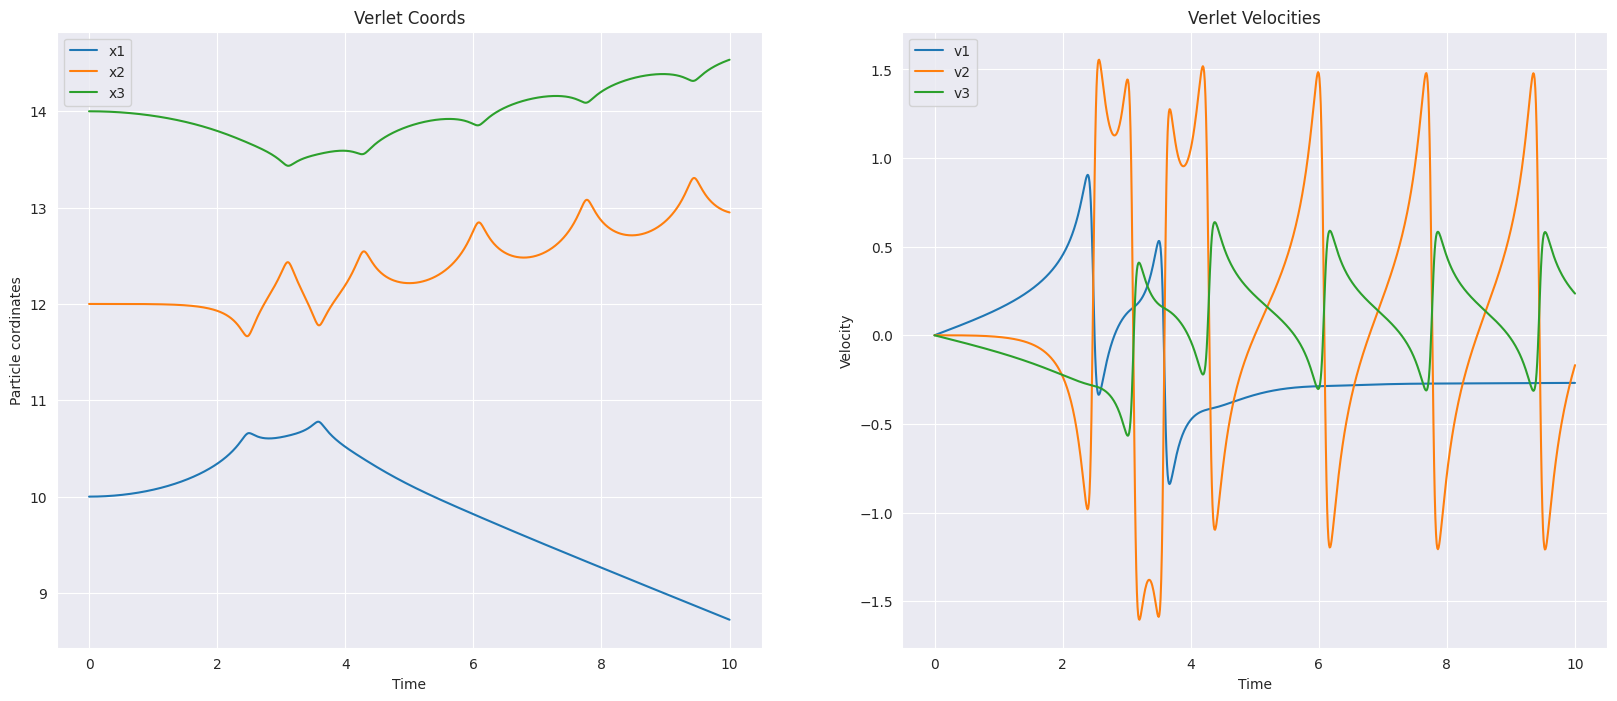

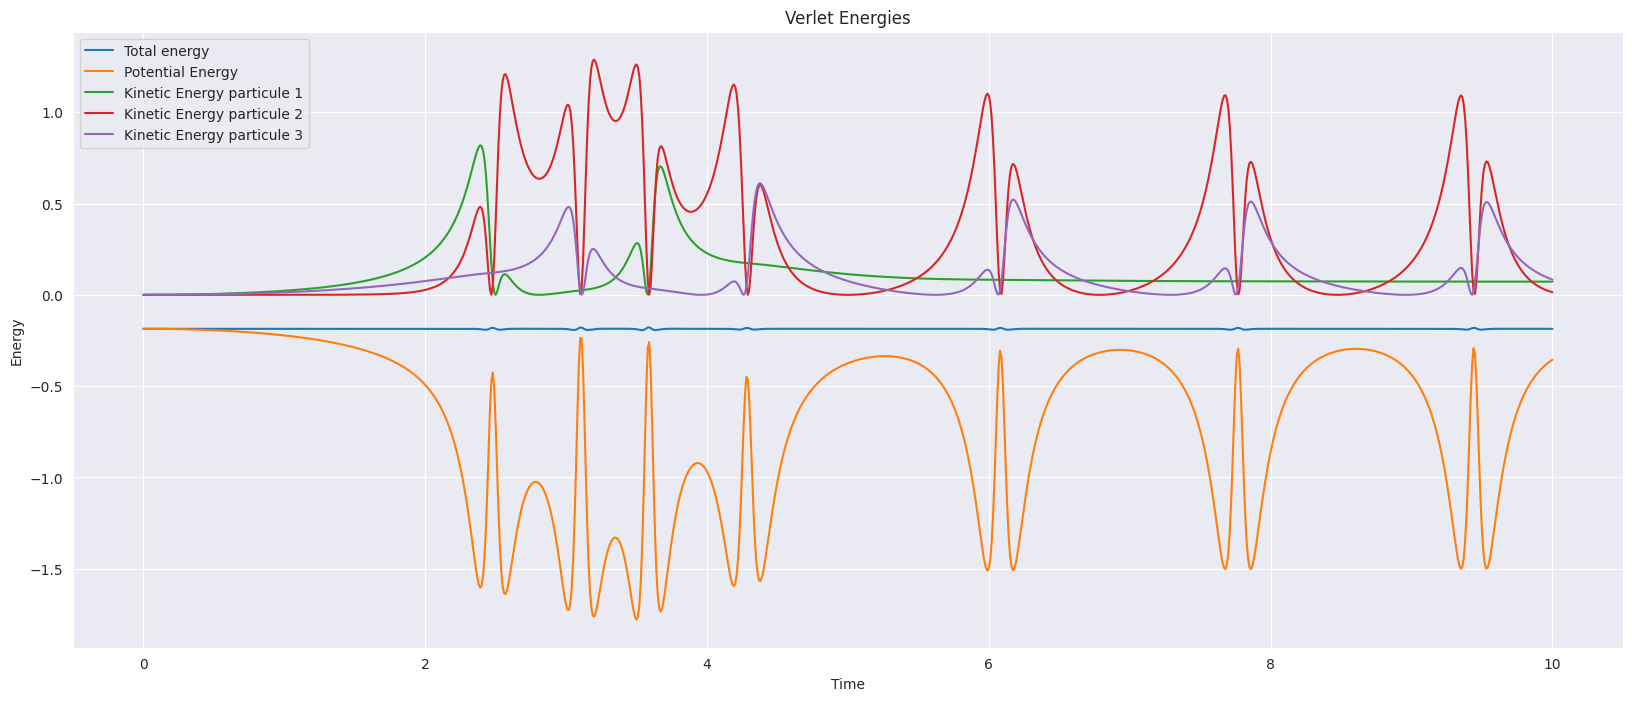

In [142]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=x1_verlet,
    ax=axes[0],
    label='x1',
)
sns.lineplot(
    x=time,
    y=x2_verlet,
    ax=axes[0],
    label='x2',
)
sns.lineplot(
    x=time,
    y=x3_verlet,
    ax=axes[0],
    label='x3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=v1_verlet,
    ax=axes[1],
    label='v1',
)
sns.lineplot(
    x=time,
    y=v2_verlet,
    ax=axes[1],
    label='v2',
)
sns.lineplot(
    x=time,
    y=v3_verlet,
    ax=axes[1],
    label='v3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=total_energy_verlet,
    ax=ax,
    label='Total energy',
)
sns.lineplot(
    x=time,
    y=potential_verlet,
    ax=ax,
    label='Potential Energy',
)
sns.lineplot(
    x=time,
    y=energy_kinetic1_verlet,
    ax=ax,
    label='Kinetic Energy particule 1',
)
sns.lineplot(
    x=time,
    y=energy_kinetic2_verlet,
    ax=ax,
    label='Kinetic Energy particule 2',
)
sns.lineplot(
    x=time,
    y=energy_kinetic3_verlet,
    ax=ax,
    label='Kinetic Energy particule 3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Energy')
plot.set_title("Verlet Energies");